In [1]:


import numpy as np
import matplotlib.pyplot as plt
from tick.hawkes import HawkesKernelPowerLaw, SimuHawkes, HawkesKernelTimeFunc
from tick.base import TimeFunction
%matplotlib inline

A=[]
B=[]
A_grad=[]
B_grad=[]
tseriesA = np.array([])
epsilon = 1e-8
delta=1
alpha=1
beta=4
mu_t=0.05
Dict={}
Dict_gradient={}
Dict_integrate={}
#power kernel = alpha*(delta+t)^(-beta)

#simulation part
def simu_univariate(alpha,beta,mu,T):
    np.random.seed(seed=None)
    lambda_int=mu
    s=0
    tau=[]
    tau.append(0)
    lambda_val=[]
    time_value=[]
    time_value.append(0)
    lambda_val.append(lambda_int+alpha*np.sum(np.exp(-beta*(s-tau[i])) for i in range(len(tau))))
    while s<T:
        sumx=0
        new_tau = tau[::-1]
        for i in range(len(new_tau)):
            sumx = sumx + np.exp(-beta * (s - new_tau[i]))
            if np.exp(-beta*(s-new_tau[i]))<=0.0001:
                break
        lambda_ = lambda_int + alpha * sumx

        u=np.random.uniform(0,1,1)[0]
        w=-np.log(u)/lambda_
        s=s+w
        d=np.random.uniform(0,1,1)[0]
        sumx = 0

        for i in range(len(new_tau)):
            sumx = sumx + np.exp(-beta * (s - new_tau[i]))
            if np.exp(-beta * (s - new_tau[i])) <= 0.0001:
                break
        lambda_s = lambda_int + alpha * sumx
        time_value.append(s)
        if (d*lambda_<=lambda_s):
            t=s
            tau.append(t)
    return tau
#likelihood estimation
def simu_tick_generic(alpha,delta,beta,mu,T):
    dx=0.01
    tk = np.arange(0,6,dx)
    t_values1 = tk
    y=alpha*beta*((tk>delta)*(tk<(delta+1/beta)))
    tf1 = TimeFunction([t_values1, y],
                   inter_mode=TimeFunction.InterConstRight, dt=0.01)
    kernel1 = HawkesKernelTimeFunc(tf1)
    #kernel=HawkesKernelPowerLaw(alpha, delta, beta)#alpha=0.5,delta=1,beta=3
    hawkes = SimuHawkes(n_nodes=1, end_time=T,seed=None)

    hawkes.set_kernel(0,0,kernel1)
    hawkes.set_baseline(0, mu)
    hawkes.simulate()
    tau= hawkes.timestamps
    return tau




def sim_powerlaw(alpha,delta,beta,mu,T):

    multiplier = alpha
    cutoff = delta
    exponent = beta

    support = 100
    kernel1 = np.array(HawkesKernelPowerLaw(multiplier, cutoff, exponent, support)).reshape(-1,1)

    hawkes = SimuHawkes(kernels=kernel1, baseline=[mu], verbose=False)
    hawkes.end_time = T
    hawkes.simulate()
    tau = hawkes.timestamps
    
    return tau

    
def inflectionPoints():
   
    div = B[0]+epsilon*(np.abs(B[0])<epsilon)
    x = -B[1]/div
    interestX1 = x*(x>0)
    alwaysInclude = (x<=0)*(B[0]>0) #dont change
    alwaysExclude = (x<=0)*(B[0]<0)
    tempX = x*(~alwaysInclude)*(~alwaysExclude)
    interestX1 = tempX[interestX1>0]
    interestX = np.sort(interestX1)
    interestX = np.append(0,interestX)
    
    Dict['inflection'] = interestX
   
    con = A[0]*B[0]
    Dict['constant'] = con
    return

def loglikelihood(para):
    alpha=para[0]
    beta =para[1]
    mu=para[2]
    
    tend = t[-1]-t
    
    ll= mu*t[-1]+(alpha/beta)*len(t)
    ll2 = np.sum(-(alpha/beta)*np.exp(-beta*tend))
    ll = ll+ll2-np.log(mu)
    print('exp',ll,(alpha/beta)*len(t))
    for i in range(2,len(t)+1,1):
        li = max(i-30,0)
        temp = t[i-1]-t[li:i-1]
        
        logLam = -np.log(mu+np.sum(alpha*np.exp(-beta*temp)))
        ll = ll+logLam
    return ll

def loglikelihood_rect(para):
    alpha=para[0]
    beta =para[1]
    delta = para[2]
    mu=para[3]
    
   
    
    tend = t[-1]-t
    condition1 = (tend>(delta+1/beta))
    condition2 = (tend>delta)*(tend<(delta+1/beta))
    ll= mu*t[-1]
    ll2 = np.sum(alpha*(condition1)+alpha*beta*(tend-delta)*(condition2))
    ll = ll+ll2-np.log(mu)
    llinit=ll
   
    for i in range(2,len(t)+1,1):
        li = max(i-50,0)*0
        temp = t[i-1]-t[li:i-1]
        
        logLam = -np.log(mu+np.sum(alpha*beta*((temp>delta)*(temp<(delta+1/beta)))))
        ll = ll+logLam
    print('rect',ll2,llinit+np.log(mu), ll-llinit-np.log(mu))
    return ll

def loglikelihood_power(para):
    alpha=para[0]
    delta = para[1]
    beta =para[2]
    mu=para[3]
    
    tend = t[-1] - t
    
    expon = (-beta)+1
    num = ((delta+tend)**expon)-(delta**expon)
    ll= mu*t[-1]
    ll2 = np.sum(alpha*num/expon)
    ll = ll+ll2-np.log(mu)

    for i in range(2,len(t)+1,1):
        li = max(i-30,0)
        temp = t[i-1]-t[li:i-1]
        
        logLam = -np.log(mu+np.sum(alpha*((delta+temp)**(-beta))))
        ll = ll+logLam
    return ll


def gradientll(para,iArray):
    alpha=para[0]
    beta =para[1]
    mu=para[2]
    tend = t[-1]-t
    grad = np.array([0.0, 0.0, 0.0])
    for i  in np.nditer(iArray):
        li = max(i-50,0)
        temp = t[i]-t[li:i]
        decayFactor = sum(np.exp(-beta*temp))
        lam = mu+alpha*decayFactor
        fac1 = np.exp(-beta*tend[i])
        fac2 = (alpha/beta)*(-(1/beta)+fac1*((1/beta)+tend[i]))
        fac3 = (alpha/lam)*(sum(temp*np.exp(-beta*temp)))+fac2
        grad[0] = grad[0]+(1/beta)*(1-fac1)-(1/lam)*decayFactor
        grad[1]= grad[1]+fac3
        grad[2] = grad[2]+ ((t[i]-t[i-1])-(1/lam))*(i >0)
        
       
        
        
    return grad/len(iArray)

def sgdHawkes(para):
    alpha=para[0]
    beta =para[1]
    mu=para[2]
    lr =0.01
    beta_1 = 0.9
    beta_2 =0.999
    epsilon = 1e-8
    count = 0
    bestll = 1e8
    bestpara = np.array([0.,0.,0.])
    m_t = np.array([0.,0.,0.])
    v_t = np.array([0.,0.,0.])
    for epochs in range(1,30,1):
        
        rsample = np.random.choice(len(t),len(t)-1,replace = False)
        for i in range(1,len(rsample),50):
            count=count+1 
            grad = gradientll(para,rsample[i:i+50])
            m_t = beta_1*m_t + (1-beta_1)*grad	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad*grad)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            para = para-(lr*m_cap)/(np.sqrt(v_cap)+epsilon)
            
            error=loglikelihood(para)
            bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            para = np.maximum(para,0)
            bestll = min(bestll,error)
            
            print(i,error,bestll,para,bestpara)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara  
    

def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)
    
def nnIntegratedKernel(x):
    x = x.reshape(-1)
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    const1 = Dict.get('constant')
    interestX = Dict.get('inflection')
    precalculate_integrate()
    
    y = np.zeros([1,len(x)])
    
    for i in range(0,len(x)):
        xi = x[i]
        if(xi>0):
            iP = max(interestX[interestX<xi])
            n1 = betas*(xi-epsilon) + beta0
            dn1 = (n1>0)
            const =np.dot(const1.T,dn1)
            
            
            term1 = nnKernel(xi)*((const!=0)+xi*(const==0))
            term2 = nnKernel(iP)*((const!=0)+iP*(const==0))
            
            const = (const)*(const!=0)+(const==0)*1.0
            
            prev_term = Dict_integrate.get(iP)
            
            y[0,i] = prev_term + ((term1-term2)/(const))
        
       
               

    return y

def nnKernel(x):
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y    


def initializeParams(nNeurons):
    alphas = -(np.random.uniform(0,1,nNeurons)).reshape(-1,1)*0.5
    alpha0 = -np.random.uniform(0,1,1)*0.5
    betas = (np.random.uniform(0,1,nNeurons)).reshape(-1,1)*0.5
    beta0 = np.random.uniform(0,1,nNeurons).reshape(-1,1)*0.05
    mu =np.random.uniform(0,1,1)
    
    A.append(alphas)
    B.append(betas)
    A.append(alpha0)
    B.append(beta0)
    A_grad.append(np.zeros([nNeurons,1]))
    A_grad.append(0)
    B_grad.append(np.zeros([nNeurons,1]))
    B_grad.append(np.zeros([nNeurons,1]))
    return mu

def precalculate_integrate():
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    iP = Dict.get('inflection')
    const1 = Dict.get('constant')
    Dict_integrate.clear()
    Dict_integrate[0]=0
    y = 0
    for index in range(1,len(iP)):
        n1 = betas*(iP[index]-epsilon) + beta0
        dn1 = (n1>0)
        const =np.dot(const1.T,dn1)
            
            
        term1 = nnKernel(iP[index])*((const!=0)+iP[index]*(const==0))
        term2 = nnKernel(iP[index-1])*((const!=0)+iP[index-1]*(const==0))
            
        const = (const)*(const!=0)+(const==0)*1.0
              
        y= y + ((term1-term2)/(const))
        Dict_integrate[iP[index]]=y
    
    
def precalculate_gradient():
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    gradA = alphas*0
    gradB1 = gradA
    gradB0 = gradB1
    gradA0=0
    iP = Dict.get('inflection')
    
    const1 = Dict.get('constant')
    Dict_gradient.clear()
    Dict_gradient[0]=list([gradA0,gradA,gradB1,gradB0])
    for index in range(1,len(iP)):
            
            n0pr = betas*(iP[index-1]+epsilon)+beta0
            n1pr = betas*(iP[index]-epsilon) + beta0
            dn1 = (n1pr>0)
            dn0 = (n0pr>0)
            const =np.dot(const1.T,dn1)
            indicator = const==0
            const = const*(const!=0)+1*(const==0)
            n0 = betas*(iP[index-1])+beta0
            n1 = betas*(iP[index]) + beta0
            
            fac1 = nnKernel(iP[index])
            fac2 = nnKernel(iP[index-1])
            gradA0 = gradA0 + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(iP[index]-iP[index-1])
            gradA = gradA -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
            gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            gradB1 = gradB1 -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
            gradB1 = gradB1 + ((1/const)*(alphas)*(fac1*iP[index]*dn1-fac2*iP[index-1]*dn0))*(~indicator)
            gradB0 = gradB0+ ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)
            Dict_gradient[iP[index]]= list([gradA0,gradA,gradB1,gradB0])
    
    return
        
            
         
    
def gradientNetwork(iArray,mu,t):
    alphas = A[0]
    alpha0 = A[1]
    betas = B[0]
    beta0 = B[1]
    precalculate_gradient()
    tend = t[-1]-t
    x = tend[iArray]
    const1 = Dict.get('constant')
    gradA = alphas*0
    gradB1 = gradA
    gradB0 = gradB1
    gradA0=0
    grad_mu = 0
    
    interestX = Dict.get('inflection')
    temp = 0
    for xi in np.nditer(x):
        if(xi>0):
            iP = max(interestX[interestX<xi])
            n1pr = betas*(xi-epsilon) + beta0
            n0pr = betas*(iP+epsilon)+beta0
           
            dn1 = (n1pr>0)
            dn0 = (n0pr>0)
            const =np.dot(const1.T,dn1)
            indicator = const==0
            const = const*(const!=0)+1*(const==0)
            n0 = betas*(iP)+beta0
            n1 = betas*(xi) + beta0
            fac1 = nnKernel(xi)
            fac2 = nnKernel(iP)
            gradients = Dict_gradient.get(iP)
            
            
            gradA0 = gradA0+gradients[0] + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(xi-iP)
            
            gradA = gradA + gradients[1] -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
            gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            
            gradB1 = gradB1+gradients[2] -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
            gradB1 = gradB1+ ((1/const)*(alphas)*(fac1*xi*dn1-fac2*iP*dn0))*(~indicator)
    
            gradB0 =gradB0+ gradients[3] + ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)
        
         
    for i in np.nditer(iArray):
        li = max(i-10,0)
        temp = t[i]-t[li:i]
        fac1 = nnKernel(temp.reshape(1,-1))
        decayFactor = np.sum(fac1)
        lam = mu+decayFactor
        invLam = (1/lam)
        n1 = np.dot(betas,temp.reshape(1,-1)) + beta0
        gradA = gradA-np.sum(invLam*(fac1*np.maximum(n1,0)),axis=1).reshape(-1,1)
        
        gradA0 = gradA0 - invLam*decayFactor
        
        gradB1 = gradB1 - invLam*np.sum(fac1*(n1>0)*alphas*temp.reshape(1,-1),axis=1).reshape(-1,1)
        gradB0 = gradB0 - invLam*np.sum(fac1*(n1>0)*alphas,axis=1).reshape(-1,1)
        grad_mu = grad_mu + ((t[i]-t[i-1])-invLam)*(i >0)
        
    gradA = gradA/len(iArray)
    gradB1 = gradB1/len(iArray)
    gradB0 = gradB0/len(iArray)
    gradA0 = gradA0/len(iArray)
    A_grad[0] = gradA
    A_grad[1] = gradA0
    B_grad[0] = gradB1
    B_grad[1] = gradB0
    return (grad_mu/len(iArray))





def plotKernels(mu):
   
    
    dx=0.01
    tk = np.arange(0,5,dx)
    interestX = Dict.get('inflection')
    if(kernelType == 0):
        #y = alpha*np.exp(-beta*tk)
        y=(alpha*np.exp(-beta*tk))
    elif(kernelType == 1):
        y = alpha*beta*((tk>delta)*(tk<(delta+1/beta)))
    elif(kernelType == 2):
        y=  alpha*(delta+tk)**(-beta)
    
    plt.plot(tk,nnKernel(tk.reshape(1,-1)).reshape(-1,1),'r--')

    plt.plot(tk,y,'b--')
    
    #if(kernelType == 0):
        #y = (alpha/beta)*(1 - np.exp(-beta*tk))
    #elif(kernelType == 1):
        
        #condition1 = (tk>(delta+1/beta))
        #condition2 = (tk>delta)*(tk<(delta+1/beta))
        #y= alpha*(condition1)+alpha*beta*(tk-delta)*(condition2)
    

    #ytemp = nnKernel(tk.reshape(1,-1))
    #intYtemp = np.cumsum(ytemp*dx)


    #plt.plot(tk,intYtemp.reshape(-1,1),'k--')
    #plt.plot(tk,nnIntegratedKernel(tk.reshape(1,-1)).reshape(-1,1),'r--')

    #plt.plot(tk,y,'b--')
    plt.grid()
    plt.pause(0.0005)
    
    return 0

def nnLoglikelihood(mu):
    
    
    tend = (t[-1]-t)
    a = np.sum(nnIntegratedKernel(tend.reshape(1,-1)))
   
    ll = mu*t[-1]+a
    ll = ll-np.log(mu)
    llInit = ll+np.log(mu)
    
    nElements = max(t.shape)
    
    
    for i in range(2,nElements+1,1):
        li = max(i-30,0)
        temp = t[i-1]-t[li:i-1]
        
        z = np.sum(nnKernel(temp.reshape(1,-1)))
        
        
        logLam = -np.log(mu+z)
        
        ll = ll+logLam
    #print('nn',a,llInit,ll-llInit-np.log(mu))
    return ll


def nnLoglikelihoodTest(mu,t):
    
    
    tend = (t[-1]-t)
    a = np.sum(nnIntegratedKernel(tend.reshape(1,-1)))
   
    ll = mu*t[-1]+a
    ll = ll-np.log(mu)
    llInit = ll+np.log(mu)
    
    nElements = max(t.shape)
    
    
    for i in range(20,nElements+1,1):
        li = max(i-20,0)
        temp = t[i-1]-t[li:i-1]
        
        z = np.sum(nnKernel(temp.reshape(1,-1)))
        
        
        logLam = -np.log(mu+z)
        
        ll = ll+logLam
    #print('nn',a,llInit,ll-llInit-np.log(mu))
    return ll
 
def sgdNeuralHawkes(nEpochs,lr,mu,t):
    global optimalParams
    lr2 =lr*0.5
    lr_mu = lr*0.1
    beta_1 = 0.9
    beta_2 =0.999
    bestll = bestll1= 1e8
    neg_ll = []
    t_train=t[0:int(len(0.8*t))]
    t_test=t[int(len(0.8*t))-20:]
    t=t_train

    m_t_A = np.zeros([nNeurons,1])
    m_t_A0 =0
    m_t_B= np.zeros([nNeurons,1])
    m_t_B0= np.zeros([nNeurons,1])
    m_t = 0
    v_t_A = np.zeros([nNeurons,1])
    v_t_A0 =0
    v_t_B= np.zeros([nNeurons,1])
    v_t_B0= np.zeros([nNeurons,1])
    v_t = 0
    count = 0
    stopping_count=0
    for epochs in range(1,nEpochs+1,1):
        
        inflectionPoints()
           
        rsample = np.random.choice(len(t),len(t)-1,replace = False)
        for i in range(1,len(rsample),50):
            count=count+1 
            
            grad = gradientNetwork(rsample[i:i+50],mu,t)
            
            m_t = beta_1*m_t + (1-beta_1)*grad	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad*grad)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            mu = mu-(lr_mu*m_cap)/(np.sqrt(v_cap)+epsilon)
            mu = np.maximum(mu,0)
        
            
            m_t_A = beta_1*m_t_A + (1-beta_1)*A_grad[0]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(A_grad[0]*A_grad[0])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            A[0] = A[0]-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*A_grad[1]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(A_grad[1]*A_grad[1])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            A[1] = A[1]-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon)
            
                
            m_t_B = beta_1*m_t_B + (1-beta_1)*B_grad[0]	#updates the moving averages of the gradient
            v_t_B = beta_2*v_t_B + (1-beta_2)*(B_grad[0]*B_grad[0])	#updates the moving averages of the squared gradient
            m_cap_B = m_t_B/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B= v_t_B/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[0] = B[0]-(lr2*m_cap_B)/(np.sqrt(v_cap_B)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*B_grad[1]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(B_grad[1]*B_grad[1])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[1] = B[1]-(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
          
            inflectionPoints()
            
            if epochs >2 and count>=int(len(rsample)/(50*5)):
                error1= nnLoglikelihoodTest(mu,t_test)
                neg_ll.append(error1)
                count=0
                if(bestll1 > error1):
                    optimalParams = list([A[0],A[1],B[0],B[1],mu])
                    stopping_count=0
                else:
                    stopping_count+=1
            
                bestll1 = min(bestll1,error1)
                print(i,epochs,bestll1,error1,mu)
                plotKernels(mu)
        if stopping_count>=20:
            break
        #error=nnLoglikelihood(mu)
        #neg_ll.append(error)
        #bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            
        #if(bestll > error):
           # A0 = np.array(A[0])
           # A1 =np.array(A[1])
           # B0 = np.array(B[0])
            #B1= np.array(B[1])
            #optimalParams=list([A0,A1,B0,B1,mu])
               
            
        #bestll = min(bestll,error)
        #print(i,epochs,bestll,error,mu)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
           
    
    return optimalParams, neg_ll, nEpochs



In [2]:
def simu_uniKernel(alpha,beta,mu,T):
    np.random.seed(seed=None)
    lambda_int=mu
    s=0
    tau=[]
    tau.append(0)
    lambda_val=[]
    time_value=[]
    time_value.append(0)
    lambda_val.append(np.exp(lambda_int))
    while s<T:
        sum=1
        new_tau = tau[::-1]
        for i in range(len(new_tau)):
            sum = (sum * kernel1(alpha,beta,s-new_tau[i]))
        lambda_ = np.exp(lambda_int)*sum

        u=np.random.uniform(0,1,1)[0]
        w=-np.log(u)/lambda_
        s=s+w
        d=np.random.uniform(0,1,1)[0]
        sum = 1

        for i in range(len(new_tau)):
            sum = sum*(kernel1(alpha,beta,s-new_tau[i]))
        lambda_s = np.exp(lambda_int) *sum
        time_value.append(s)
        if (d*lambda_<=lambda_s):
            t=s
            tau.append(t)
            lambda_val.append(lambda_s)
    return tau


def kernel1(alpha,beta,t):
    y=alpha*np.exp(-beta*t)
    return np.exp(y)
def kernel2(t):
    
    y=alpha*np.exp(-beta*t)
    return (y)






def integratedKernel(mu,t1,t2,temp):
    n=500
    h=(t2-t1)/n
   
    intgr=0
    intgr=intgr+h*np.sum(np.exp(mu+np.sum(kernel2((t1+i*h)-temp))) for i in range(0,n-1))
    return intgr
    
def loglikelihoodpara1(para,t):
    alpha=para[0]
    beta =para[1]
    mu=para[2]
    integrated1=0
    for j in range(1,len(t)):
        tj=t[j]
        if tj>0:
            ip=t[j-1]
            ti=max(j-20,0)
            temp=t[ti:j]
        
            integrated1=integrated1+np.sum(integratedKernel(mu,ip,tj,temp))
    ll=integrated1
    ll = ll-mu
    print("type,","integrated part,","likelihood")
    print('product exp',ll)
    for i in range(2,len(t)+1,1):
        li = max(i-30,0)
        temp = t[i-1]-t[li:i-1]
        logLam = -(mu+np.sum(kernel2(temp)))
        ll = ll+logLam
    return ll

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


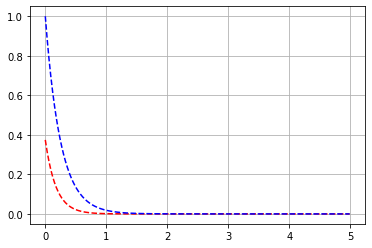

exp 4000.3481321766653 997.5
13263.275097524103
1 3 [3054.9965458] [3054.9965458] [0.0507348]


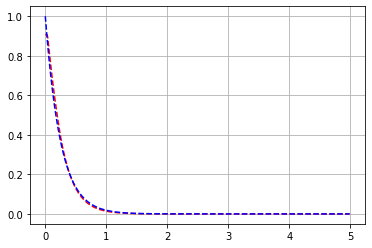

751 3 [3054.9965458] [3082.62174952] [0.05119652]


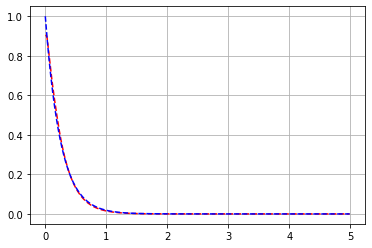

1501 3 [3054.9965458] [3121.75154682] [0.05184812]


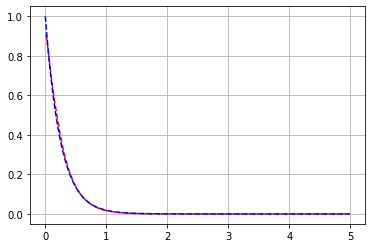

2251 3 [3014.67815619] [3014.67815619] [0.0500543]


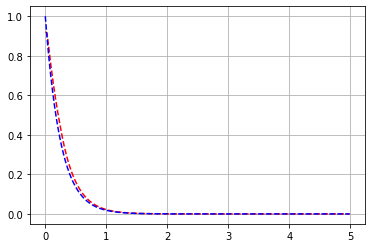

3001 3 [2922.5902147] [2922.5902147] [0.04854398]


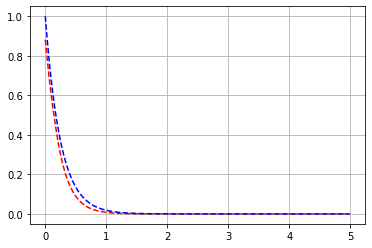

3751 3 [2922.5902147] [3001.88237118] [0.04985914]


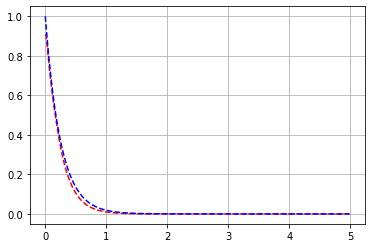

501 4 [2922.5902147] [3009.15186076] [0.04997766]


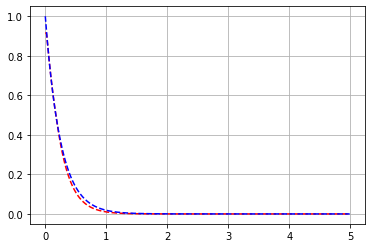

1251 4 [2922.5902147] [2971.69402686] [0.04935229]


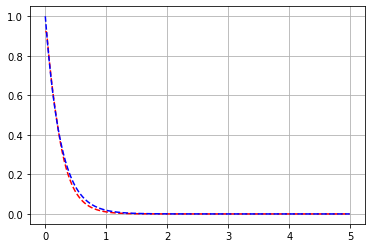

2001 4 [2922.5902147] [2978.29093575] [0.0494638]


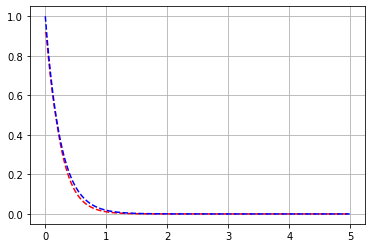

2751 4 [2922.5902147] [3025.25001431] [0.05023653]


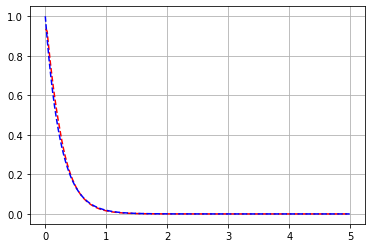

3501 4 [2922.5902147] [3057.02905189] [0.05077453]


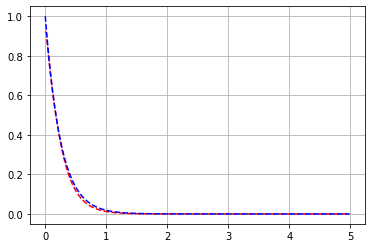

251 5 [2922.5902147] [3103.68741988] [0.05154574]


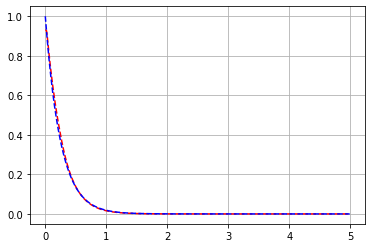

1001 5 [2922.5902147] [3047.60483366] [0.05062039]


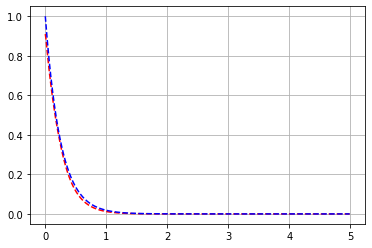

1751 5 [2922.5902147] [3029.65817862] [0.05031066]


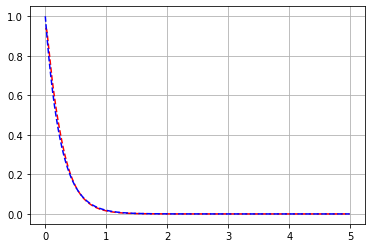

2501 5 [2922.5902147] [3104.17823783] [0.05155205]


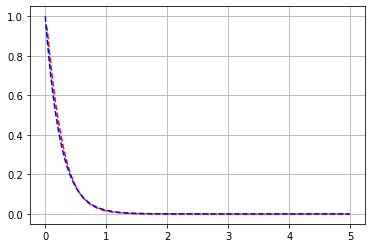

3251 5 [2922.5902147] [3040.02211378] [0.05049289]


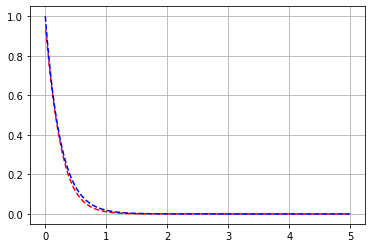

1 6 [2922.5902147] [3000.5862826] [0.04983914]


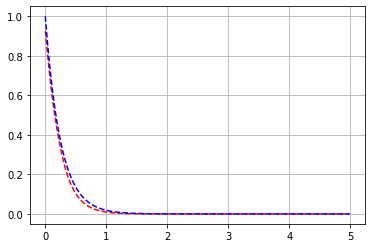

751 6 [2922.5902147] [3012.66291871] [0.05003012]


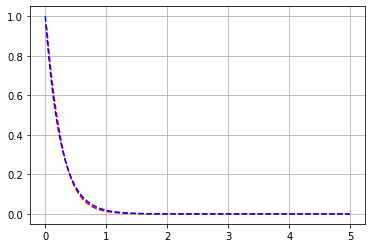

1501 6 [2922.5902147] [2987.66929305] [0.04961973]


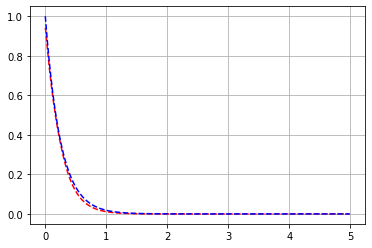

2251 6 [2922.5902147] [2981.88922096] [0.04952619]


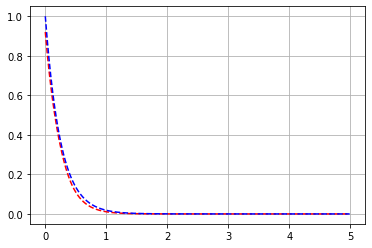

3001 6 [2922.5902147] [3071.40700199] [0.05101092]


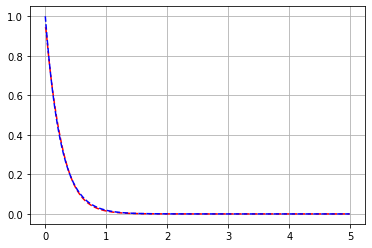

3751 6 [2922.5902147] [3075.62778676] [0.05108053]


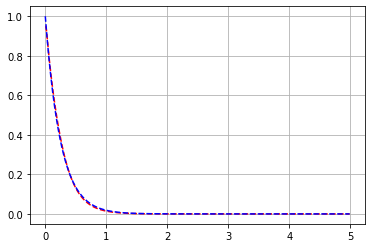

501 7 [2922.5902147] [3073.0483249] [0.05103248]


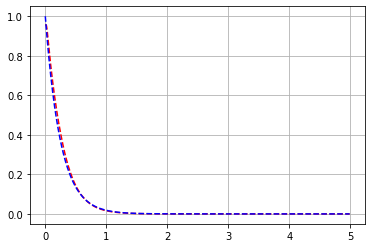

1251 7 [2922.5902147] [3069.0860966] [0.0509757]


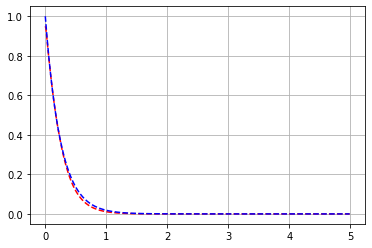

2001 7 [2922.5902147] [3141.5891047] [0.05218211]


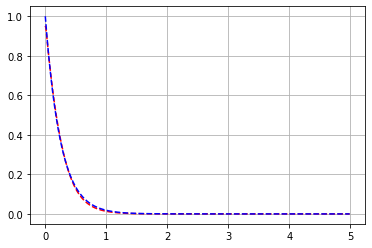

2751 7 [2922.5902147] [3093.34012748] [0.0513804]


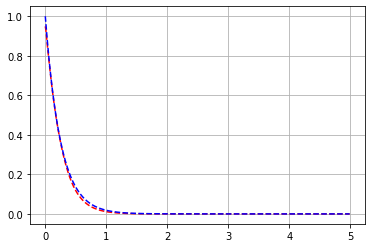

3501 7 [2922.5902147] [3016.11301517] [0.05009358]


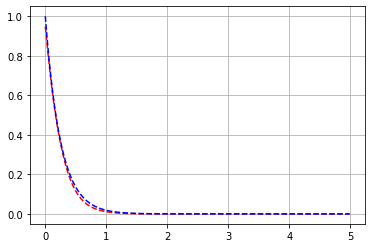

--- 14.300636768341064 seconds ---


In [3]:
import time

nNeurons=100
kernelType = 0
if(kernelType == 0):
    tseries = simu_univariate(alpha,beta,mu_t,60000)
    #tseries=simu_uniKernel(alpha,beta,mu_t,5000)
elif(kernelType == 1):
    tseries = simu_tick_generic(alpha,delta,beta,mu_t,60000)
elif(kernelType == 2):
    tseries = sim_powerlaw(alpha,delta,beta,mu_t,60000)
    
t = np.array(tseries)
t=t.reshape(-1)

x = initializeParams(nNeurons)


inflectionPoints()
plotKernels(x)
           
if(kernelType == 1):
    print(loglikelihood_rect(np.array([alpha,beta,delta,mu_t])))
    
elif(kernelType==2):
    #print(loglikelihood(np.array([alpha,beta,mu])),nnLoglikelihood(mu))
    print(loglikelihood_power([alpha,delta,beta,mu_t]))
else:
    print(loglikelihood([alpha,beta,mu_t]))


start_time = time.time()

SGD = sgdNeuralHawkes(30,0.01,x,t)
print("--- %s seconds ---" % (time.time() - start_time))
#sgdNeuralHawkes(30,0.001,x)



## This is the main method.

In [4]:
def nnOptimalKernel(x):

    tem = optimalParams[0]
    tem1 = optimalParams[1]
    alphas = optimalParams[0].reshape(-1,1)
    alpha0 = optimalParams[1].reshape(-1,1)
    betas = optimalParams[2].reshape(-1,1)
    beta0 = optimalParams[3].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y


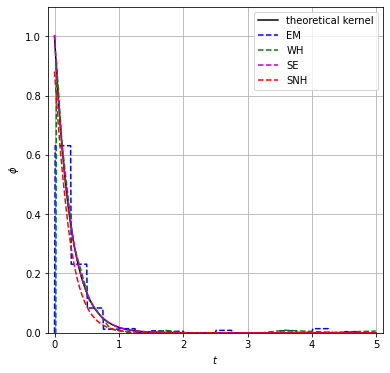

In [5]:
#Kernel plot

from tick.hawkes import HawkesEM, HawkesConditionalLaw,HawkesSumExpKern
timestamp = t

em = HawkesEM(kernel_support = 5, kernel_size=20, n_threads=1, verbose=False, tol=1e-3)
wh = HawkesConditionalLaw(n_quad=50)
learner = HawkesSumExpKern(decays = [beta], penalty='elasticnet',
                           elastic_net_ratio=0.8)

timestamp = timestamp.astype('float64') 
h_time = [timestamp]

em.fit(h_time)
wh.fit(h_time)
learner.fit(h_time)

#checking the attributes
c_nodes = em.n_nodes

dx=0.01
tk = np.arange(0,5,dx)

if(kernelType == 0):
    y = alpha*np.exp((-beta*tk))
elif(kernelType == 1):
    y = alpha*beta*((tk>delta)*(tk<(delta+1/beta)))
elif(kernelType == 2):
    y=  alpha*(delta+tk)**(-beta)


fig, axs = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(6, 6))


axs.plot(tk,y,'k', label = 'theoretical kernel')

    
ax_list_list = np.array([[axs]])

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        y_values = em.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'b--', label='EM')
        y_values = wh.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'g--', label='WH')
        y_values = learner.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'m--', label='SE')

        
#ax_list_list.ravel()[0].figure
axs.plot(tk,nnOptimalKernel(tk.reshape(1,-1)).reshape(-1,1),'r--', label = 'SNH')
axs.grid()
plt.legend(fontsize=10)
#plt.title('Exponential Kernel')
plt.xlabel(r'$t$')
plt.ylabel(r'$\phi$')
#plt.tight_layout()
plt.axis([-0.1, 5.1, 0, 1.1])
plt.savefig("1D_exp_kernel.png",dpi=300)

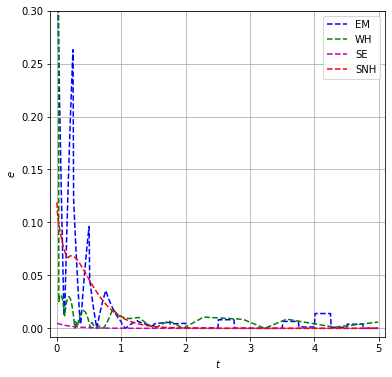

In [6]:
#L1 error


#checking the attributes
c_nodes = em.n_nodes

dx=0.01
tk = np.arange(0,5,dx)

if(kernelType == 0):
    y = alpha*np.exp(-beta*tk)
elif(kernelType == 1):
    y = alpha*beta*((tk>delta)*(tk<(delta+1/beta)))
elif(kernelType == 2):
    y=  alpha*(delta+tk)**(-beta)


fig, axs = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(6, 6))

    
ax_list_list = np.array([[axs]])

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        em_values = em.get_kernel_values(i, j, tk)
        error1 = (np.abs(y-em_values))
        ax.plot(tk, error1,'b--', label='EM')
        wh_values = wh.get_kernel_values(i, j, tk)
        error2 = (np.abs(y-wh_values))
        ax.plot(tk, error2,'g--', label='WH')
        se_values = learner.get_kernel_values(i, j, tk)
        error3 = (np.abs(y-se_values))
        ax.plot(tk, error3,'m--', label='SE')

        
        
#ax_list_list.ravel()[0].figure
y_values = nnOptimalKernel(tk.reshape(1,-1)).reshape(-1,1)
error = np.abs(y-y_values.reshape(-1))
axs.plot(tk,error,'r--', label = 'SNH')
axs.grid()
plt.legend(fontsize=10,loc='upper right')
#plt.title('Error estimate for exponential kernel')
plt.xlabel(r'$t$')
plt.ylabel(r'$e$')
plt.axis([-0.1, 5.1, -0.008, 0.3])
plt.savefig("1D_exp_error.png",dpi=300)
#print(error,error1,error2,error3)